## Obligatory imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (1.5,1)

# We use the MNIST Dataset again

In [2]:
import IPython
url = 'http://yann.lecun.com/exdb/mnist/'
iframe = '<iframe src=' + url + ' width=80% height=400px></iframe>'
IPython.display.HTML(iframe)

## Fetch the data

In [3]:
from sklearn.datasets import fetch_mldata

In [4]:
mnist = fetch_mldata('MNIST original', data_home='data/')

In [5]:
allimages = mnist.data
allimages.shape

(70000, 784)

In [6]:
all_image_labels = mnist.target
set(all_image_labels)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}

## check out the data

In [7]:
digit1 = mnist.data[0,:].reshape(28,-1) # arr.reshape(4, -1) is equivalent to arr.reshape(4, 7), is arr has size 28

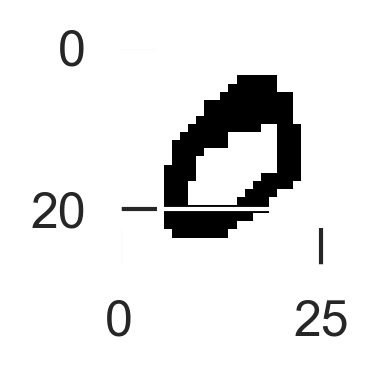

In [8]:
plt.imshow(digit1, vmin=0, vmax=1)

## Classify using Neural networks
![nn-singlelayer](http://scikit-learn.org/stable/_images/multilayerperceptron_network.png)


### The math
* The *input layer* has **dimention = number of features.**
* For each training example, each feature value is "fed" into the input layer. 
* Each "neuron" in the hidden layer receives a weighted sum of the features: the weight is initialized to a random value in the beginning, and the network "learns" from the datasetsand tunes these weights. Each hidden neuron, based on its input, and an "activation function", typically something like:
![actfunc](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Activation_tanh.svg/320px-Activation_tanh.svg.png)
* The output is again, a weighted sum of the values at each hidden neuron. 
* There can be *more than one hidden layer*, in which case the output of the first hidden layer becomes the input of the second hidden layer.  

### Regularization
Like Logistic regression and SVM, neural networks also can be improved with regularization.
Fot scikit-learn, the relevant tunable parameter is `alpha` (as opposed to `gamma` for LR and SVM). 
Furthermore, it has default value 0.0001, unlike gamma, for which it is 1. 

In [ ]:
MLPClassifier()

### Separate the data into training data and test data

In [9]:
len(allimages)

70000

### Sample the data, 70000 is too many images to handle on a single PC

In [24]:
len(allimages)

70000

In [25]:
size_desired_dataset = 2000

In [26]:
sample_idx = np.random.choice(len(allimages), size_desired_dataset)
images = allimages[sample_idx, :]
image_labels = all_image_labels[sample_idx]

In [27]:
set(image_labels)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}

In [28]:
image_labels.shape

(2000,)

### Partition into training and test set *randomly*

**As a rule of thumb, 80/20 split between training/test dataset is often recommended.**
See below for cross validation and how that changes this thumbrule.


In [29]:
from scipy.stats import itemfreq

In [30]:
from sklearn.model_selection import train_test_split

In [119]:
training_data, test_data, training_labels, test_labels = train_test_split(images, image_labels, train_size=0.8)

** Importance of normalization** 
If  Feature A is in the range [0,1] and Feature B is in [10000,50000], SVM (in fact, most of the classifiers) will suffer inaccuracy.
The solution is to *normalize* (AKA "feature scaling") each feature to the same interval e.g. [0,1] or [-1, 1].

**scipy provides a standard function for this:**

In [126]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data: IMPORTANT
scaler.fit(training_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [120]:
from sklearn.neural_network import MLPClassifier

In [136]:
clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter = 5000)
clf.fit(scaler.transform(training_data), training_labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [137]:
clf.score(scaler.transform(training_data), training_labels), clf.score(scaler.transform(test_data), test_labels)

(1.0, 0.89000000000000001)

### Visualize the hidden layer:

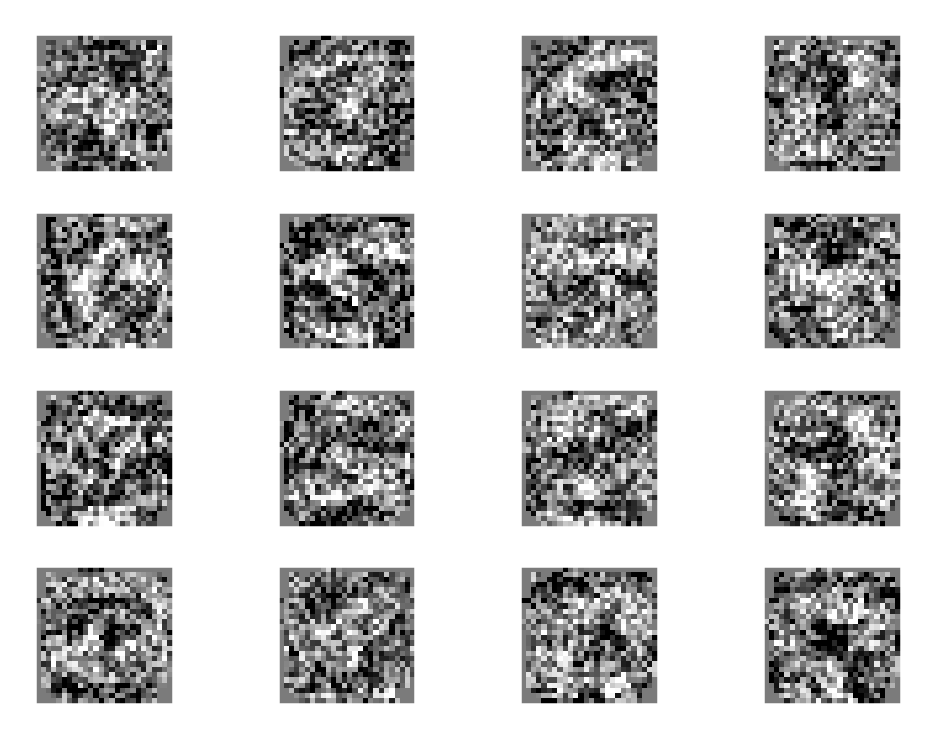

In [138]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = clf.coefs_[0].min(), clf.coefs_[0].max()
for coef, ax in zip(clf.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

Not bad, but is it better than Logistic regression? Check out with Learning curves:

In [53]:
from sklearn.model_selection import learning_curve
import pandas as pd

/home/dmanik/projects/mpi/pyd3t/.devenv34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


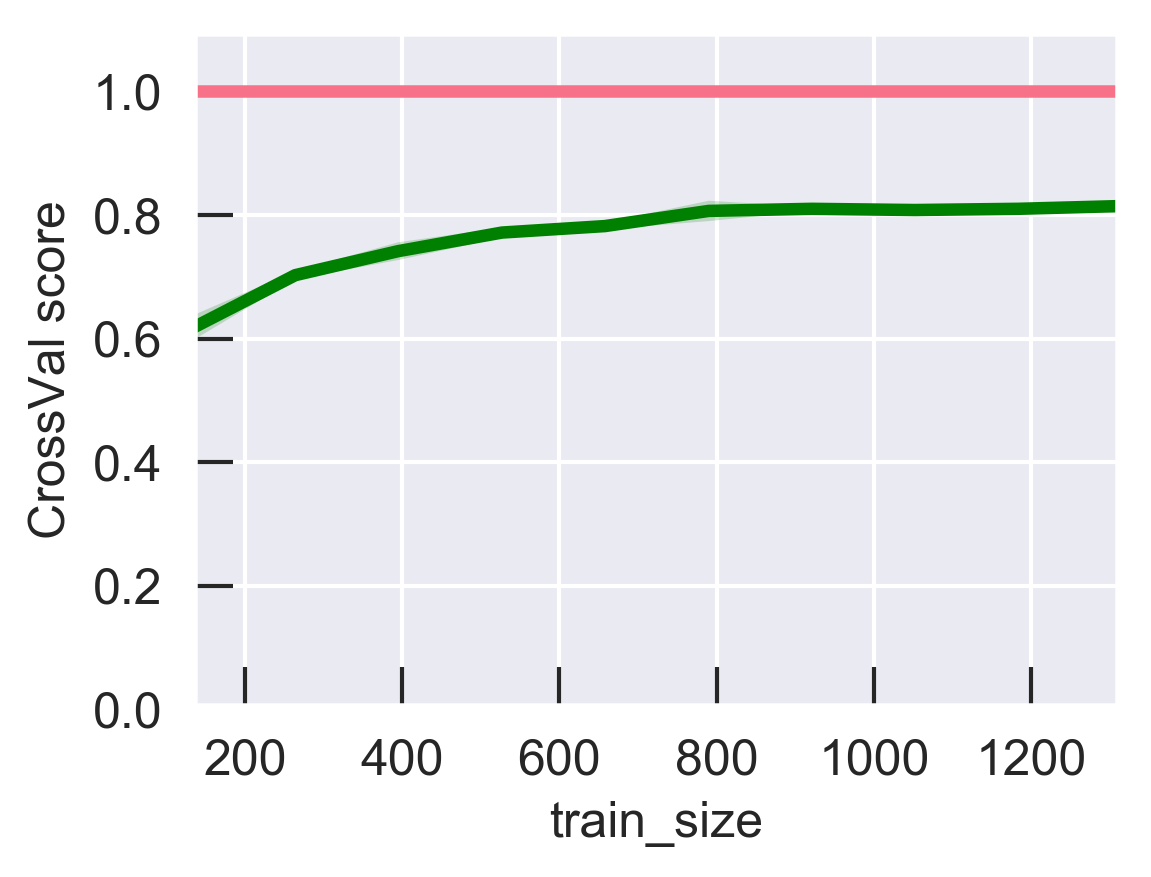

In [54]:
curve = learning_curve(clf, images, image_labels, train_sizes= np.linspace(0.1,0.99,10).astype(float), n_jobs = 12)
train_sizes, train_scores, test_scores = curve

train_scores = pd.DataFrame(train_scores)
train_scores.loc[:,'train_size'] = train_sizes
test_scores = pd.DataFrame(test_scores)
test_scores.loc[:,'train_size'] = train_sizes

train_scores = pd.melt(train_scores, id_vars=['train_size'], value_name = 'CrossVal score')
test_scores = pd.melt(test_scores, id_vars=['train_size'], value_name = 'CrossVal score')

matplotlib.rcParams['figure.figsize'] = (4,3)
sns.tsplot(train_scores, time = 'train_size', unit='variable', value = 'CrossVal score')
sns.tsplot(test_scores, time = 'train_size', unit='variable', value = 'CrossVal score', color='g')
plt.ylim(0,1.1)

plt.legend()

Not really, we can trry to improve it with parameter space search.

## Parameter space search with `GridSearchCV`

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
image_labels.shape

(2000,)

In [59]:
clr = MLPClassifier()

In [60]:
clf = GridSearchCV(clr, {'alpha':np.logspace(-8, -1, 9)}, n_jobs = 14)

In [61]:
clf.fit(images, image_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=14,
       param_grid={'alpha': array([  1.00000e-08,   7.49894e-08,   5.62341e-07,   4.21697e-06,
         3.16228e-05,   2.37137e-04,   1.77828e-03,   1.33352e-02,
         1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [62]:
clf.best_params_

{'alpha': 0.00023713737056616554}

In [63]:
clf.best_score_

0.83799999999999997

In [66]:
nn_tuned = MLPClassifier()
nn_tuned.set_params(**clf.best_params_)
nn_tuned.fit(training_data, training_labels)

MLPClassifier(activation='relu', alpha=0.00023713737056616554,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

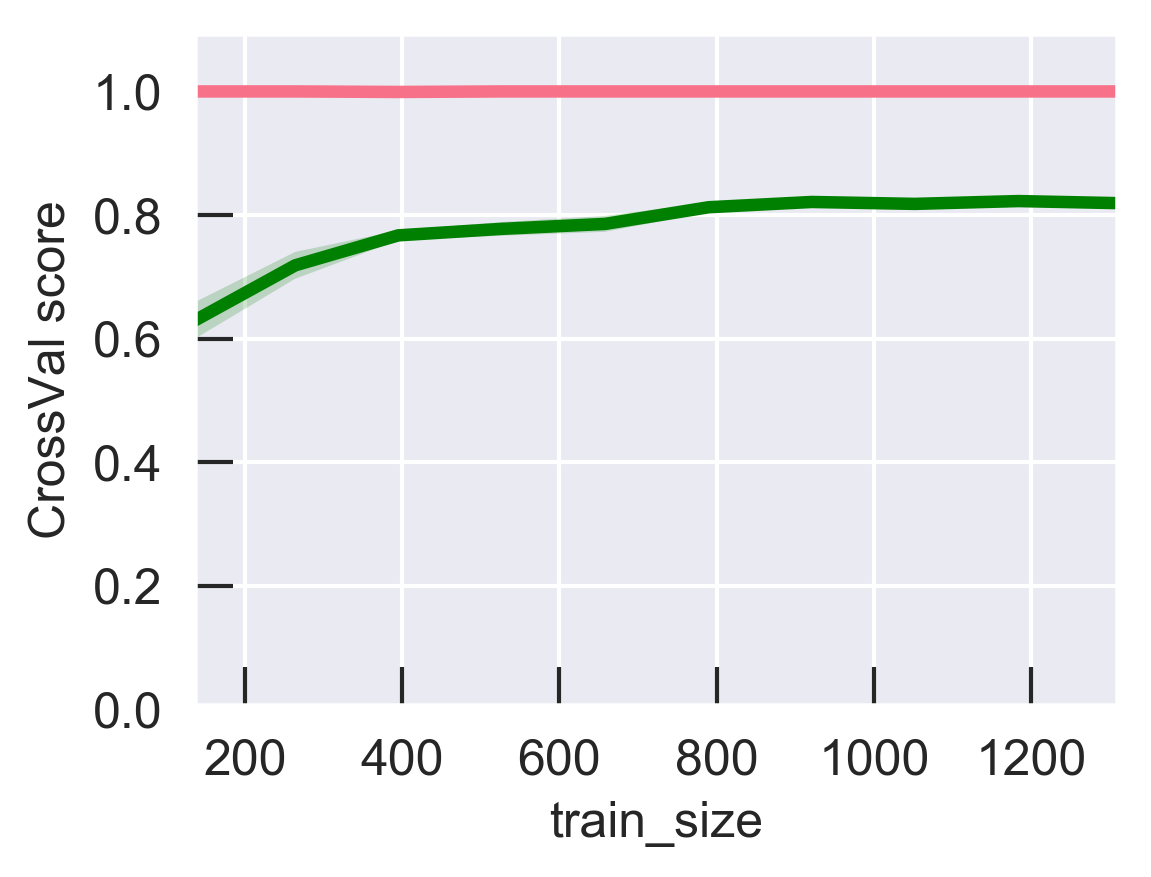

In [67]:
curve = learning_curve(nn_tuned, images, image_labels, train_sizes= np.linspace(0.1,0.99,10).astype(float), n_jobs = 12)
train_sizes, train_scores, test_scores = curve

train_scores = pd.DataFrame(train_scores)
train_scores.loc[:,'train_size'] = train_sizes
test_scores = pd.DataFrame(test_scores)
test_scores.loc[:,'train_size'] = train_sizes

train_scores = pd.melt(train_scores, id_vars=['train_size'], value_name = 'CrossVal score')
test_scores = pd.melt(test_scores, id_vars=['train_size'], value_name = 'CrossVal score')

matplotlib.rcParams['figure.figsize'] = (4,3)
sns.tsplot(train_scores, time = 'train_size', unit='variable', value = 'CrossVal score')
sns.tsplot(test_scores, time = 'train_size', unit='variable', value = 'CrossVal score', color='g')
plt.ylim(0,1.1)

plt.legend()

The increase in accuracy is miniscule.

## Multi layered NN's

In [100]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(images)

images_normed = scaler.transform(images)

/home/dmanik/projects/mpi/pyd3t/.devenv34/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [106]:
clr = MLPClassifier(hidden_layer_sizes=(50,2), max_iter = 800)
clf = GridSearchCV(clr, {'alpha':np.logspace(-80, -1, 10)}, n_jobs = 14)
clf.fit(images_normed, image_labels)
clf.best_params_
clf.best_score_

0.65500000000000003

In [108]:
clf.best_params_

{'alpha': 9.9999999999999996e-81}

In [113]:
nn_tuned = clf.best_estimator_
nn_tuned.fit(scaler.transform(training_data), training_labels)

MLPClassifier(activation='relu', alpha=9.9999999999999996e-81,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(50, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)

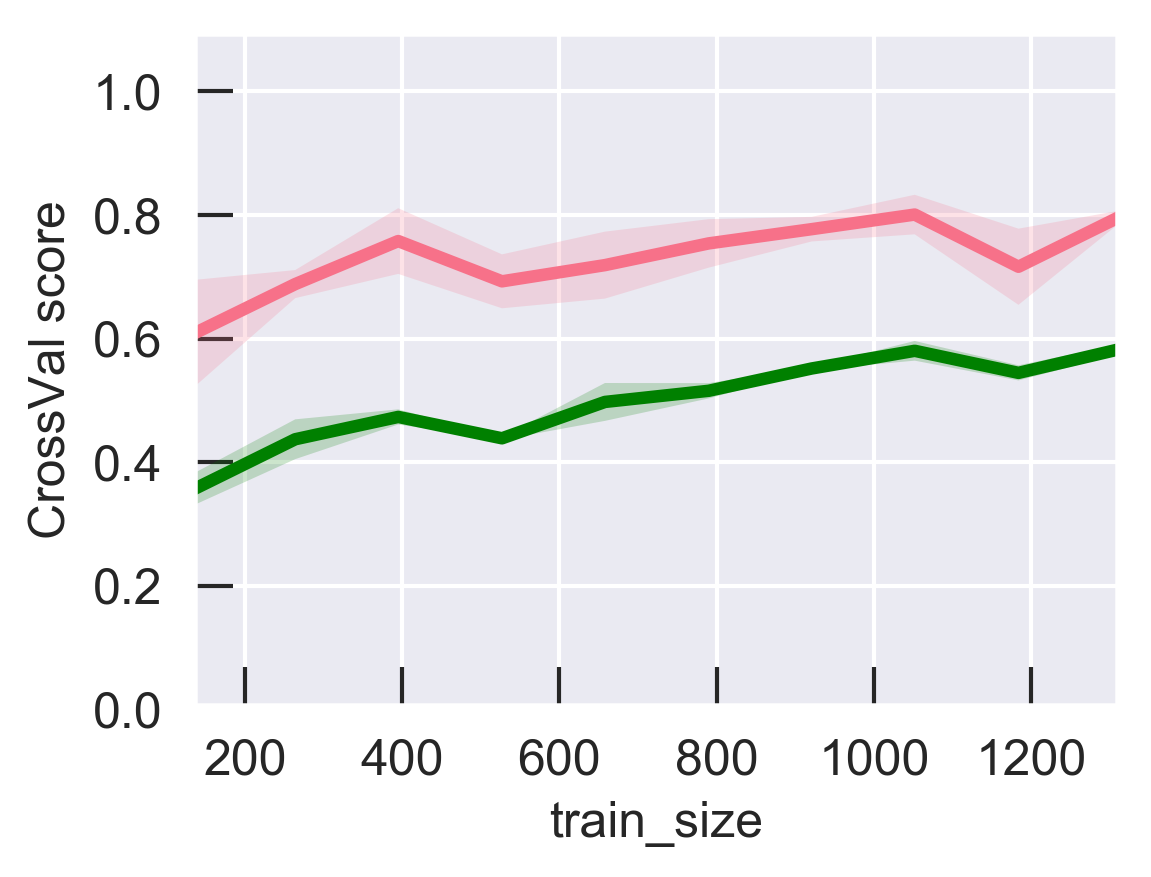

In [114]:
curve = learning_curve(nn_tuned, images_normed, image_labels, train_sizes= np.linspace(0.1,0.99,10).astype(float), n_jobs = 12)
train_sizes, train_scores, test_scores = curve

train_scores = pd.DataFrame(train_scores)
train_scores.loc[:,'train_size'] = train_sizes
test_scores = pd.DataFrame(test_scores)
test_scores.loc[:,'train_size'] = train_sizes

train_scores = pd.melt(train_scores, id_vars=['train_size'], value_name = 'CrossVal score')
test_scores = pd.melt(test_scores, id_vars=['train_size'], value_name = 'CrossVal score')

matplotlib.rcParams['figure.figsize'] = (4,3)
sns.tsplot(train_scores, time = 'train_size', unit='variable', value = 'CrossVal score')
sns.tsplot(test_scores, time = 'train_size', unit='variable', value = 'CrossVal score', color='g')
plt.ylim(0,1.1)

plt.legend()

Hmm... multi-hidden layer NN's seem to be much harder to tune.
Maybe we need to try with wider range of parameters for Gridsearch?

Finding optimum parameters for advanced classifiers is not always so straightforward, and quite often the most time consuming part. This so-called **Hyperparameter optimization** is a topic in itself, and has numerous approaches and libraries. 

* [http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html](http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html)
* [Practical Bayesian Optimization of Machine Learning Algorithms](https://dash.harvard.edu/handle/1/11708816)

**sklearn's neural network functionality is rather limited.** More advanced toolboxes for neural networks:
* [keras](https://keras.io/)
* [tensorflow](https://www.tensorflow.org/)
* [Theano](http://deeplearning.net/software/theano/)

# Exercise

## iris dataset
Train a neural network on the `iris` dataset and run cross validation. Do not forget to normalize the featurs. 
Compare the results against LogisticRegression.

Use Grid search to tune the NN further.

## Further reading
* http://www.ritchieng.com/applying-machine-learning/
    